In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
img_height,img_width=256,256
batch_size=10

In [3]:
data_dir="Data"
Classes=[]
for file in os.listdir(data_dir):
    Classes+=[file]
print(Classes)

['Normal', 'Sick']


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_generator = train_datagen.flow_from_directory(data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training')
test_generator = train_datagen.flow_from_directory(data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation')

Found 2217 images belonging to 2 classes.
Found 949 images belonging to 2 classes.


In [5]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_height,img_width, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 96)       0

In [6]:
model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy"])
hist=model.fit_generator(train_generator,epochs=10,validation_data=test_generator,verbose=1)

C:\Users\ymts0427\AppData\Local\Temp\ipykernel_10672\1616187481.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=10,validation_data=test_generator,verbose=1)


Epoch 1/10
222/222 [==============================] - 132s 591ms/step - loss: 0.0990 - accuracy: 0.9635 - val_loss: 0.0956 - val_accuracy: 0.9705
Epoch 2/10
222/222 [==============================] - 135s 609ms/step - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.1301 - val_accuracy: 0.9642
Epoch 3/10
222/222 [==============================] - 167s 752ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.4110 - val_accuracy: 0.9505
Epoch 4/10
222/222 [==============================] - 131s 590ms/step - loss: 0.0875 - accuracy: 0.9869 - val_loss: 0.2073 - val_accuracy: 0.9642
Epoch 5/10
222/222 [==============================] - 128s 578ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.2417 - val_accuracy: 0.9705
Epoch 6/10
222/222 [==============================] - 134s 603ms/step - loss: 3.4219e-04 - accuracy: 1.0000 - val_loss: 0.1805 - val_accuracy: 0.9747
Epoch 7/10
222/222 [==============================] - 136s 611ms/step - loss: 7.8442e-06 - accuracy: 1.0000 - val_loss: 

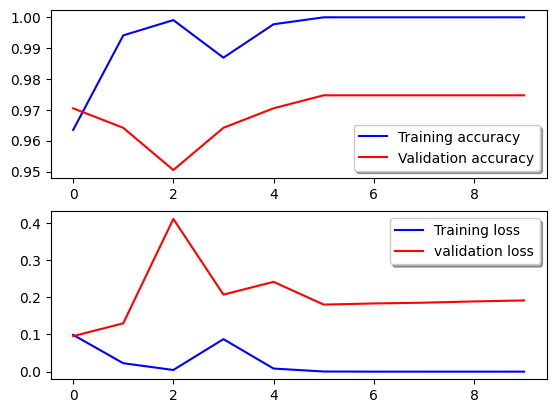

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r',label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [8]:
model.evaluate(test_generator)
model.save("CNN.h5")

95/95 [==============================] - 13s 140ms/step - loss: 0.1917 - accuracy: 0.9747


In [9]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model1 = Sequential()
model1.add(base_model)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

In [10]:
model1.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy"])
hist1=model1.fit(train_generator,epochs=10,validation_data=test_generator,verbose=1)

Epoch 1/10
222/222 [==============================] - 299s 1s/step - loss: 0.1112 - accuracy: 0.9630 - val_loss: 0.0382 - val_accuracy: 0.9884
Epoch 2/10
222/222 [==============================] - 286s 1s/step - loss: 0.0497 - accuracy: 0.9838 - val_loss: 0.0828 - val_accuracy: 0.9747
Epoch 3/10
222/222 [==============================] - 301s 1s/step - loss: 0.0272 - accuracy: 0.9937 - val_loss: 0.0401 - val_accuracy: 0.9884
Epoch 4/10
222/222 [==============================] - 307s 1s/step - loss: 0.0653 - accuracy: 0.9793 - val_loss: 2.0143 - val_accuracy: 0.7829
Epoch 5/10
222/222 [==============================] - 305s 1s/step - loss: 0.0398 - accuracy: 0.9860 - val_loss: 0.0278 - val_accuracy: 0.9905
Epoch 6/10
222/222 [==============================] - 306s 1s/step - loss: 0.0194 - accuracy: 0.9968 - val_loss: 0.1235 - val_accuracy: 0.9758
Epoch 7/10
222/222 [==============================] - 287s 1s/step - loss: 0.0284 - accuracy: 0.9946 - val_loss: 0.0241 - val_accuracy: 0.9926

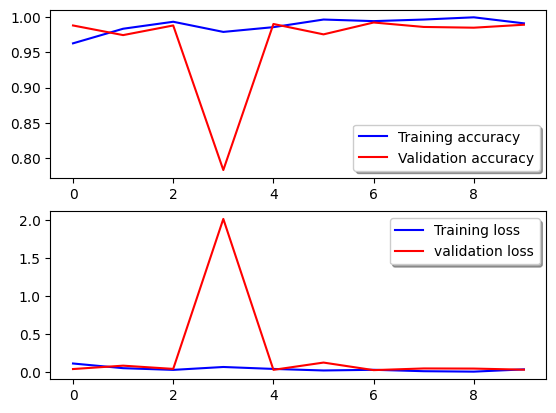

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [12]:
model1.evaluate(test_generator)
model1.save("Mobilenet.h5")

95/95 [==============================] - 20s 213ms/step - loss: 0.0299 - accuracy: 0.9895


In [13]:
Accuracy = []

for i in [hist,hist1]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[1.0, 0.99142986536026]

1/1 [==============================] - 1s 580ms/step
[2.9071571e-06 9.9999714e-01]


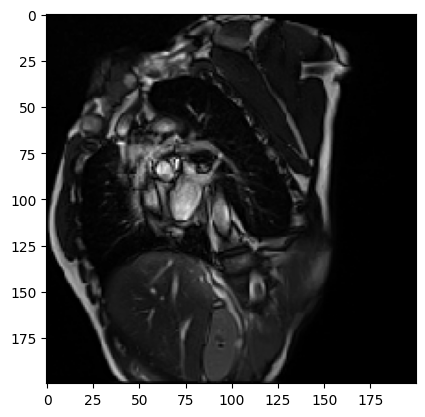

Prediction: Sick


In [14]:
from skimage import io
from tensorflow.keras.preprocessing import image

img = image.load_img(r'Data\Sick\IM00001 (10).jpg', grayscale=False, target_size=(256,256))
show_img=image.load_img(r'Data\Sick\IM00001 (10).jpg', grayscale=False, target_size=(200, 200))
Classes = Classes
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model1.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Classes[ind])